In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.contrib import connected_components

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from uloss_wmh.loss_functions.neven import *

In [4]:
"""
I need to construct an example.
For that example, I need to construct an example vector map, a seed map
and two instances lets say.

I need a:

[ ] mask
[ ] example vector map
[ ] spatial dims
[ ] 
"""

'\nI need to construct an example.\nFor that example, I need to construct an example vector map, a seed map\nand two instances lets say.\n\nI need a:\n\n[ ] mask\n[ ] example vector map\n[ ] spatial dims\n[ ] \n'

### Example label mask

In [5]:
# example label mask
gt_mask = torch.zeros((100,100))
gt_mask[20:30, 78:92] = 1 # a retangle

# a circle
centre = torch.Tensor([60, 40])
radius = 10
grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in [100,100]],
                indexing='ij'
            )
        )



In [6]:
gt_instance_mask = torch.zeros((100,100))
gt_instance_mask[20:30, 78:92] = 2

In [7]:
xy_circle_masks = (((grid - centre.unsqueeze(1).unsqueeze(1))**2).sum(dim=0) - radius**2 < 0)
#gt_mask[torch.logical_and(xy_circle_masks[0], xy_circle_masks[1])] = 1

In [8]:
gt_mask[xy_circle_masks] = 1
gt_instance_mask[xy_circle_masks] = 1

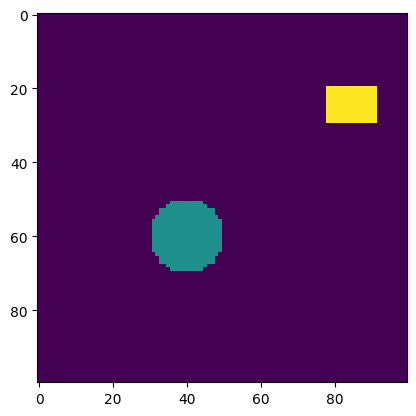

In [93]:
plt.imshow(gt_instance_mask)

### Example vector map

here I need to invent a prediction bya hypothetical model.
Lets say that it points every vector in a square around each object into the object's centre (maybe plus some noise?)
I will need two channels for an example, x and y.


In [94]:
offset_x_map = torch.zeros([100,100])
offset_y_map = torch.zeros([100,100])

# put a rectangle 12 pixels either side of the circle
offset_x_map[48:72, 28:52] = 62 - grid[0][48:72, 28:52]
offset_y_map[48:72, 28:52] = 38 - grid[1][48:72, 28:52]

# put a circle of radius 8 around the rectangle
rectangle_centre = torch.Tensor([25,85])
rect_pred_radius = 8
xy_example_pred_mask = (((grid - rectangle_centre.unsqueeze(1).unsqueeze(1))**2).sum(dim=0) - rect_pred_radius**2 < 0)
offset_x_map[xy_example_pred_mask] = (24 - grid[0][xy_example_pred_mask]).type(torch.float32)
offset_y_map[xy_example_pred_mask] = (84 - grid[1][xy_example_pred_mask]).type(torch.float32)

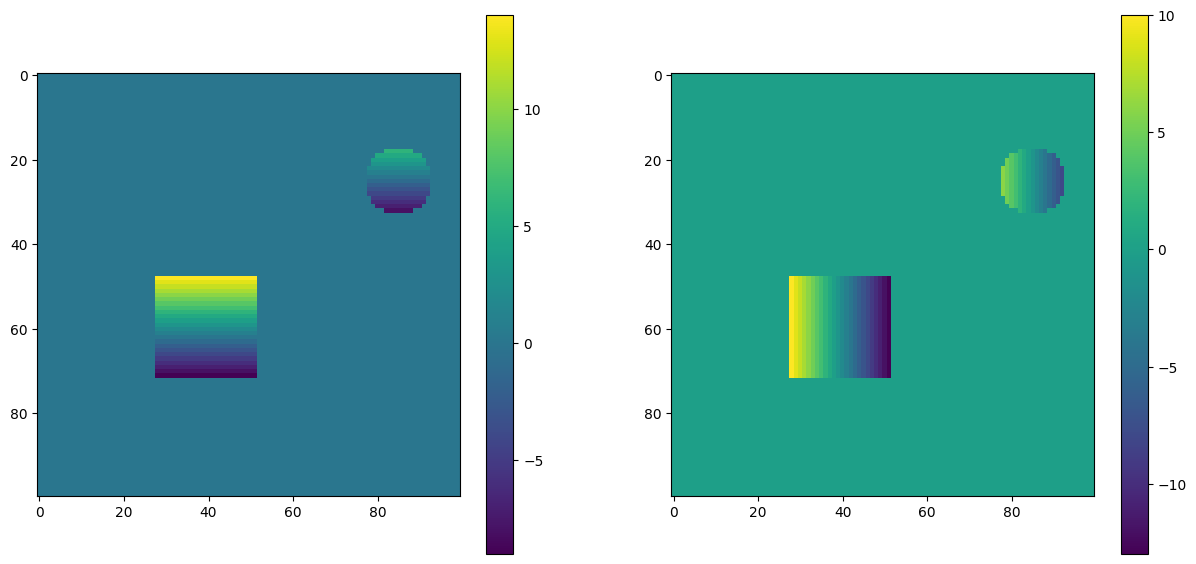

In [95]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.imshow(offset_x_map); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(offset_y_map); plt.colorbar();

### creating an example sigma map and an example seed map
I am just going to use a random vector for each of these, and just manually run through the loss with it and see
what I get...

In [96]:
log2pres = torch.randn((2,100,100))
seed = torch.randn((100,100))
sigma = (1/(2 * log2pres.exp())).sqrt()

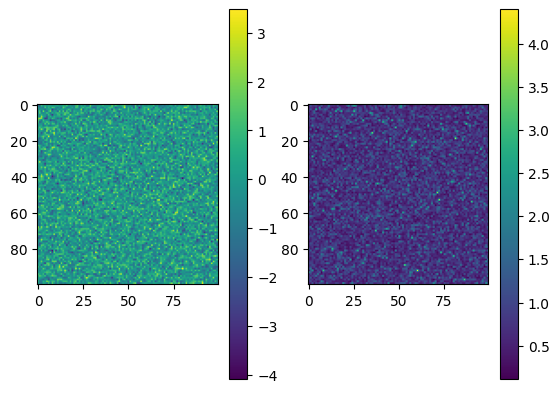

In [97]:
plt.subplot(1,2,1)
plt.imshow(seed); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sigma[0]); plt.colorbar()

this image would be a really good example to overfit on because it is so simple. Nice.

In [14]:
from monai.losses import DiceLoss

In [98]:
base_loss = DiceLoss(
    sigmoid=False,
    softmax=False,
    reduction='sum',
)

In [99]:
offset_x_map.requires_grad = True
offset_y_map.requires_grad = True
log2pres.requires_grad = True
seed.requires_grad = True

In [100]:
offset_x_map.grad

In [143]:
example_spatial_dims = [100,100]
example_label_instances = gt_instance_mask.unsqueeze(0).unsqueeze(0)
example_offsets = torch.stack([offset_x_map, offset_y_map]).unsqueeze(0)
example_log2press = log2pres.unsqueeze(0)
example_seed = seed.unsqueeze(0).unsqueeze(0)

In [144]:
activ = lambda x : torch.nn.functional.relu(x) + 1e-5

In [176]:
# lets calculate each loss in turn:

# modify the sigmas and calculate the embeddings
sigma_raw = (1/(2 * log2pres.exp())).sqrt()
sigma = activ(sigma_raw)
spatial_dims=(100,100)
pos_grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32)
scale_spatial_conv = torch.Tensor([64/100, 64/100])
rescale_factor = 1/64

example_embedding = torch.stack([
    (pos_grid[0] * scale_spatial_conv[0] + offset_x_map) * rescale_factor,
    (pos_grid[1] * scale_spatial_conv[1] + offset_y_map) * rescale_factor,
])

# mean sigmas
mean_rectangle_sigma = sigma[:,20:30, 78:92].mean(dim=(1,2))
mean_circle_sigma = sigma[:,xy_circle_masks].mean(dim=1)
print("mean sigmas: ", mean_circle_sigma.detach(), mean_rectangle_sigma.detach())

# calculate learned centre
learned_centre_circle = torch.Tensor([
    example_embedding[0][xy_circle_masks].mean(), example_embedding[1][xy_circle_masks].mean()
])
learned_centre_rectangle = torch.Tensor([example_embedding[0][20:30, 78:92].mean(), example_embedding[1][20:30, 78:92].mean()])

print("learned centres: ", learned_centre_circle, learned_centre_rectangle.detach())

# calculate instance distribution for each instance
circle_instance_distribution_learned = (-(example_embedding - learned_centre_circle.unsqueeze(-1).unsqueeze(-1)).pow(2) / (2*mean_circle_sigma.pow(2).view(2,1,1))).sum(dim=0).exp()
rectangle_instance_distribution_learned = (-(example_embedding - learned_centre_rectangle.unsqueeze(-1).unsqueeze(-1)).pow(2) / (2*mean_rectangle_sigma.pow(2).view(2, 1, 1))).sum(dim=0).exp()
print(" circle_instance_distribution_learned sum and shape: ", circle_instance_distribution_learned.sum().detach(), circle_instance_distribution_learned.shape)
print(" rectangle_instance_distribution_learned sum and shape: ", rectangle_instance_distribution_learned.sum().detach(), rectangle_instance_distribution_learned.shape)
# smooth loss
#print(mean_rectangle_sigma.shape)
rectangle_sigma_smooth_loss = (sigma[:,20:30, 78:92] - mean_rectangle_sigma.unsqueeze(-1).unsqueeze(-1)).pow(2).sum() / ((30-20) * (92-78))
circle_sigma_smooth_loss = (sigma[:,xy_circle_masks] - mean_circle_sigma.unsqueeze(-1)).pow(2).sum() / xy_circle_masks.sum()
print("circle sigma sum: ", (sigma[:,xy_circle_masks] - mean_circle_sigma.unsqueeze(-1)).pow(2).sum().detach())
print("circle mask sum: ", xy_circle_masks.sum().detach())
smooth_loss = (rectangle_sigma_smooth_loss + circle_sigma_smooth_loss) / 2
print("\n--------------")
print("circle smooth loss", circle_sigma_smooth_loss.detach())
print("rectangle smooth loss", rectangle_sigma_smooth_loss.detach())
print("smooth loss", smooth_loss.detach())

# seed loss
background_seed_loss = seed[gt_instance_mask==0].pow(2).sum()
circle_seed_loss_learned = (seed[gt_instance_mask==1] - circle_instance_distribution_learned[gt_instance_mask==1]).pow(2).sum()
rectangle_seed_loss_learned = (seed[gt_instance_mask==2] - rectangle_instance_distribution_learned[gt_instance_mask==2]).pow(2).sum()
seed_loss_learnable = (background_seed_loss + circle_seed_loss_learned + rectangle_seed_loss_learned) / (100*100)
print("\n--------------")
print("background seed loss: ", background_seed_loss.detach())
print("seed loss circle: " , circle_seed_loss_learned.detach())
print("seed loss rectangle: " , rectangle_seed_loss_learned.detach())
print("seed loss: ", seed_loss_learnable.detach())

# instance loss
instance_loss_circle_learned = base_loss(circle_instance_distribution_learned.unsqueeze(0).unsqueeze(0), (gt_instance_mask==1).unsqueeze(0).unsqueeze(0))

instance_loss_rectangle_learned = base_loss(rectangle_instance_distribution_learned.unsqueeze(0).unsqueeze(0), (gt_instance_mask==2).unsqueeze(0).unsqueeze(0))

instance_loss_learned = (instance_loss_circle_learned + instance_loss_rectangle_learned)/2

print("\n--------------")
print(" instance loss circle: ",instance_loss_circle_learned.detach())
print(" instance loss rectangle: ",instance_loss_rectangle_learned.detach())
print("instance loss: ", instance_loss_learned.detach())

# overall loss
loss_learned = instance_loss_learned + seed_loss_learnable + smooth_loss
print("\n--------------")
print("loss learnable centre: ", loss_learned.detach())

mean sigmas:  tensor([0.8321, 0.8338]) tensor([0.8103, 0.7584])
learned centres:  tensor([0.6312, 0.3688]) tensor([0.2370, 0.8352])
 circle_instance_distribution_learned sum and shape:  tensor(8703.9023) torch.Size([100, 100])
 rectangle_instance_distribution_learned sum and shape:  tensor(7666.3857) torch.Size([100, 100])
circle sigma sum:  tensor(111.4104)
circle mask sum:  tensor(305)

--------------
circle smooth loss tensor(0.3653)
rectangle smooth loss tensor(0.3335)
smooth loss tensor(0.3494)

--------------
background seed loss:  tensor(9572.6602)
seed loss circle:  tensor(569.9519)
seed loss rectangle:  tensor(272.4662)
seed loss:  tensor(1.0415)

--------------
 instance loss circle:  tensor(0.9324)
 instance loss rectangle:  tensor(0.9642)
instance loss:  tensor(0.9483)

--------------
loss learnable centre:  tensor(2.3392)


In [177]:
sigma_raw.shape

torch.Size([2, 100, 100])

In [178]:
%autoreload

In [179]:
from uloss_wmh.loss_functions.neven_concurrent import *

In [180]:
neven_loss = NevenLoss(
    base_loss = base_loss,
    sigma_normalizer=activ,#ScaledSigmoidActivation(64),
    true_spatial_dims=(100,100),
    embedding_spatial_dims=(64, 64),
    embedding_rescale_factor=1/64,
    instance_weight=1,
    seed_weight=1,
    smooth_weight=1,
)

In [181]:
loss = neven_loss(
    offset_map=example_offsets,
    sigma_map=sigma_raw.unsqueeze(0),
    seed_map=example_seed,
    labels=example_label_instances,
)

instance sigmas:  tensor([[0.8321, 0.8338],
        [0.8103, 0.7584]], grad_fn=<SqueezeBackward0>)
instance centres:  tensor([[0.6312, 0.3688],
        [0.2370, 0.8352]], grad_fn=<SqueezeBackward0>)


In [182]:
loss[0], loss[2]

(tensor(2.3392, grad_fn=<DivBackward0>),
 (tensor(0.9483), tensor(0.3494), tensor(1.0415)))

In [183]:
# the gradients won't match because I haven't reset them
# just checking that they don't break
offset_x_map.grad

### What needs to match:

- [x] sigma mean circle
- [x] sigma mean square
- [x] log2press mean circle
- [x] log2press mean square
- [x] instance loss learnable circle
- [x] instance loss learnable square
- [x] instance loss fixed circle
- [x] instance loss fixed square
- [x] smooth loss circle
- [x] smooth loss square
- [x] seed loss learnable circle
- [x] seed loss learnable square
- [x] seed loss fixed circle
- [x] seed loss fixed square
- [x] seed loss background
- [x] total instance loss fixed
- [x] total instance loss learned
- [x] total seed loss fixed
- [x] total seed loss learnable
- [x] total smooth loss
- [x] total loss

Note that the learned embeddings are off because of the use of tanh on the embeddings to scale them (as opposed
to dividing by 100 like for the fixed embeddings. However, the algorithm otherwise works!

### After getting this to work I need to try the following:

- [x] check that the gradient can track back through to the inputs
- [ ] implement a parameter for rescaling the embedding map and check that it is consistent? I haven't implemented this but I will see if I can overfit a single example first.

In [184]:
instance_loss_circle_fixed, instance_loss_circle_learned

(tensor(1.0000, grad_fn=<SumBackward0>),
 tensor(0.9324, grad_fn=<SumBackward0>))

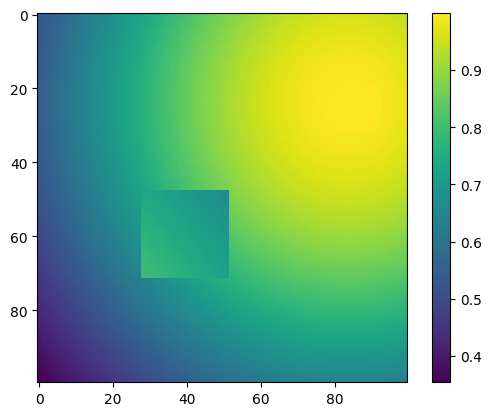

In [185]:
# im not sure that these learned distributions look right to be honest...
plt.imshow(rectangle_instance_distribution_learned.detach()); plt.colorbar()

In [186]:
sigma[:,20:30, 78:92].shape, mean_rectangle_sigma.unsqueeze(0).unsqueeze(0).shape

(torch.Size([2, 10, 14]), torch.Size([1, 1, 2]))

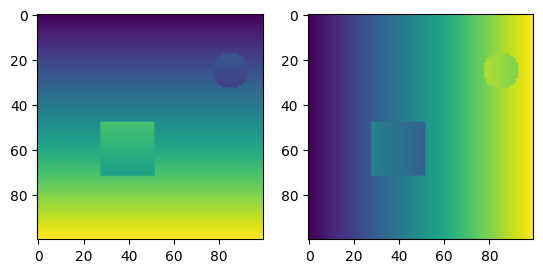

In [187]:
plt.subplot(1,2,1)
plt.imshow(example_embedding[0].detach())
plt.subplot(1,2,2)
plt.imshow(example_embedding[1].detach())

In [188]:
xy_circle_masks

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

### Overfitting on the one image

In [489]:
%autoreload
from uloss_wmh.loss_functions.neven_concurrent import *

In [490]:
activ = lambda x : torch.nn.functional.relu(x) + 5e-3#0.005
activ2 = lambda x : torch.sigmoid(x) + 0.001

In [619]:
neven_loss = NevenLoss(
    base_loss = DiceLoss(sigmoid=False,softmax=False, reduction='sum'),
    sigma_normalizer=activ,
    true_spatial_dims=(100,100),
    embedding_spatial_dims=(64, 64),
    embedding_rescale_factor=1/64,
    instance_weight=1,
    seed_weight=1,
    smooth_weight=0.1,
    debug=False
)

In [620]:
# just define a random input embedding vector
offset_vector_random = torch.randn(1, 2, 100, 100).cuda() * 0.1
sigma_map_random = 0.05 + torch.randn(1,2,100,100).cuda() * 0.01 # + 1 #+ -2.02 #-3.9#torch.randn(1, 2, 100, 100) * 3
seed_map_random = 0.01+ torch.randn(1, 1, 100, 100).cuda() * 0.1

class InputsWrapper(torch.nn.Module):
    def __init__(self, offset_vector_random, sigma_map_random, seed_map_random):
        super().__init__()

        self.offset_vector_random = torch.nn.Parameter(offset_vector_random)
        self.sigma_map_random = torch.nn.Parameter(sigma_map_random)
        # self.log_2pres_squared_random = log_2pres_squared_random
        self.seed_map_random = torch.nn.Parameter(seed_map_random)
        self.instance_distributions = []
        
    def forward(self):
        loss, instance_distributions, (ins, smth, seed) = neven_loss(
            offset_map=self.offset_vector_random,
            # log_2pres_squared=(self.log_2pres_squared_random.tanh() * 2) - 4.6,
            sigma_map=self.sigma_map_random,
            seed_map=self.seed_map_random,
            labels=example_label_instances.cuda(),
        )
        self.instance_distributions.append(instance_distributions)

        return loss, (ins, smth, seed)

In [621]:
model = InputsWrapper(offset_vector_random, sigma_map_random, seed_map_random)

In [622]:
optimizer = torch.optim.SGD(model.parameters(), lr=2)

In [631]:
for i in range(3001):
    loss, (ins, smth, seed) = model()
    loss.backward()
    if i % 1000 == 0:
        print("LOSS: ", loss.item(), ins.item(), smth.item(), seed.item())
        print(model.offset_vector_random.data[0][0][60][40])
        print(model.offset_vector_random.grad[0][0][60][40])
    optimizer.step()
    optimizer.zero_grad()

LOSS:  0.16372627019882202 0.15928122401237488 0.00014066525909584016 0.00443097623065114
tensor(-0.1261, device='cuda:0')
tensor(-9.6257e-06, device='cuda:0')
LOSS:  0.12511533498764038 0.12242117524147034 5.062256036580948e-07 0.002694100374355912
tensor(-0.1080, device='cuda:0')
tensor(-8.5001e-06, device='cuda:0')
LOSS:  0.10592420399188995 0.10447466373443604 1.36198877953575e-07 0.0014495262876152992
tensor(-0.0920, device='cuda:0')
tensor(-7.4432e-06, device='cuda:0')
LOSS:  0.08986050635576248 0.08902773261070251 3.667159020892541e-08 0.000832771765999496
tensor(-0.0781, device='cuda:0')
tensor(-6.4731e-06, device='cuda:0')


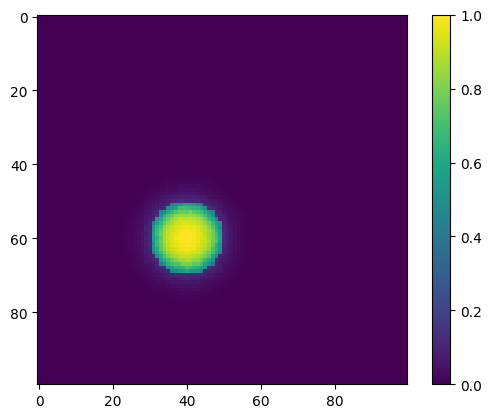

In [634]:
plt.imshow(model.instance_distributions[-1][0][0].cpu(), vmin=0, vmax=1);
plt.colorbar();

In [635]:
example_label_instances.shape

torch.Size([1, 1, 100, 100])

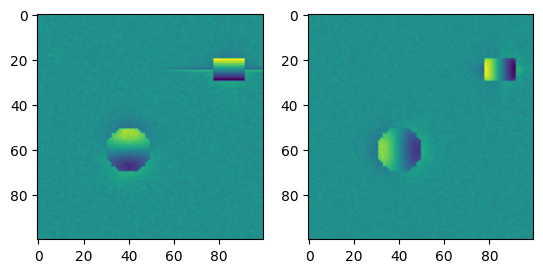

In [636]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

#embedding = grid/100 + model.offset_vector_random.detach().tanh()
# embedding = grid + model.offset_vector_random.detach().cpu()
embedding = neven_loss.embedding_vectors(model.offset_vector_random.detach()).cpu()

# plt.imshow(embedding[0,1]); plt.colorbar()
# plt.imshow(model.log_2pres_squared_random[0,0].detach()); plt.colorbar()
# plt.imshow(model.seed_map_random[0,0].detach()); plt.colorbar()
plt.imshow(model.offset_vector_random.detach().cpu()[0,0]);# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(model.offset_vector_random.detach().cpu()[0,1]);# plt.colorbar()

In [637]:
points_random = embedding.reshape((2, -1))

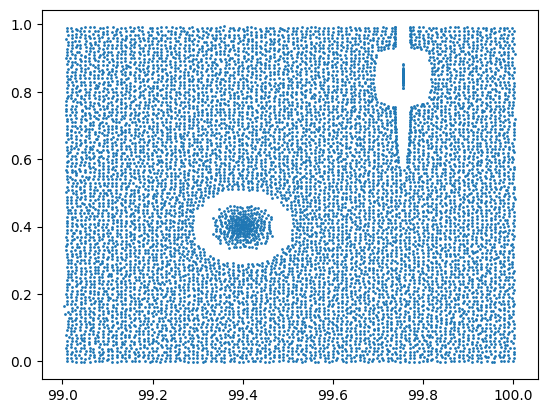

In [638]:
plt.scatter(100-points_random[0], points_random[1], s=1)

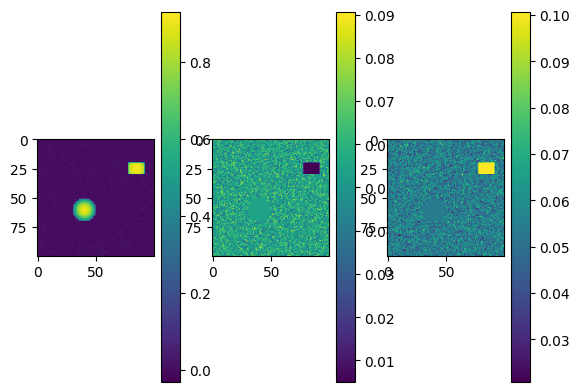

In [639]:
plt.subplot(1,3,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

sigma_random = activ(model.sigma_map_random)
plt.imshow(model.seed_map_random[0,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(sigma_random[0,0].detach().cpu()); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(sigma_random[0,1].detach().cpu()); plt.colorbar()

### list of what is working or needs checking

- [x] trains with fixed centre and full scale vectors
- [x] trains with learned centre and full scale vectors (yes works even better)
- [ ] scaling down the vectors, does it still train?
- [ ] finding a suitable way to constrain log2pres does it train?